<div style="border: 2px solid red;">
<b>
Note that some code in this notebook depends on PyMC; this is available via Anaconda:
</b>
<pre>conda install pymc</pre>
</div>

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<h2>5.7 Simple Examples of Bayesian Analysis:  Model Selection</h2>

<h3>5.7.1 Gaussian or Lorentzian Likelihood?</h3>

In the examples $\S$5.6.1 and 5.6.3 Gaussian and Lorentzian pdf's were assumed.  What if we don't know the pdf the data is drawn from?  We can compute the <b>Bayes factor</b>:

$$
B_{21} = \frac{E(M_2)}{E(M_1)}
$$

or, the <b>odds ratio</b> with the assumption the ratio of the model priors is 1, where:

$$
E(M) \equiv \int p(D|M,\vec{\theta},I)p(\vec{\theta}|M,I) d\theta
$$

(reference back to $\S$5.4 Bayesian Model Selection for details on this.)

Using data drawn from a Cauchy distribution with $\mu=0$ and $\gamma=2$, and comparing Gaussian and Lorentzian models:

Results for first 10 points:
  L(M = Cauchy) = 1.18e-12 +/- 1.92e-16
  L(M = Gauss)  = 8.09e-13 +/- 1.32e-16
  O_{CG} = 1.45 +/- 0.000237


/home/dcunning/anaconda3/envs/py27/lib/python2.7/site-packages/matplotlib/collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


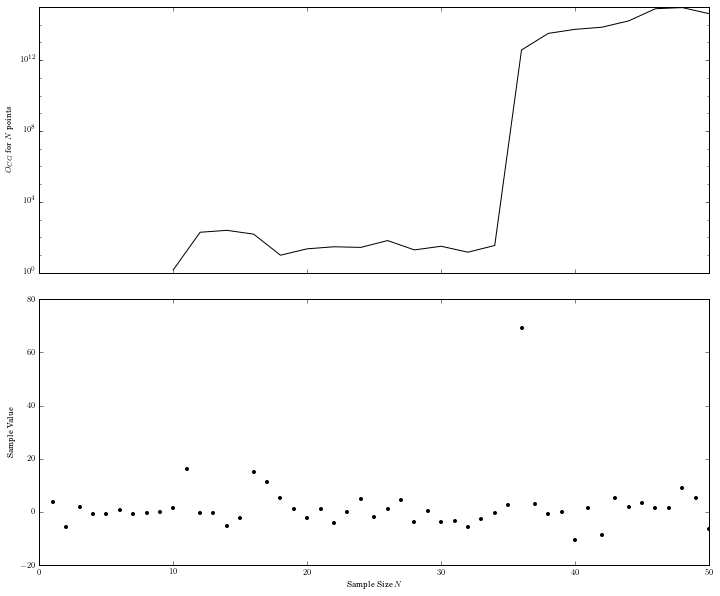

In [2]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import cauchy, norm
from scipy import integrate

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def logL_cauchy(xi, gamma, mu,
                mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(gamma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - n * np.log(np.pi)
            + (n - 1) * np.log(gamma)
            - np.sum(np.log(gamma ** 2 + (xi - mu) ** 2), 0))


def logL_gaussian(xi, sigma, mu,
                  mu_min=-10, mu_max=10, sigma_min=0.01, sigma_max=100):
    """Equation 5.57: gaussian likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    prior_normalization = - (np.log(mu_max - mu_min)
                             + np.log(np.log(sigma_max / sigma_min)))

    return (prior_normalization
            - 0.5 * n * np.log(2 * np.pi)
            - (n + 1) * np.log(sigma)
            - np.sum(0.5 * ((xi - mu) / sigma) ** 2, 0))


def calculate_odds_ratio(xi, epsrel=1E-8, epsabs=1E-15):
    """
    Compute the odds ratio by perfoming a double integral
    over the likelihood space.
    """
    gauss_Ifunc = lambda mu, sigma: np.exp(logL_gaussian(xi, mu, sigma))
    cauchy_Ifunc = lambda mu, gamma: np.exp(logL_cauchy(xi, mu, gamma))

    I_gauss, err_gauss = integrate.dblquad(gauss_Ifunc, -np.inf, np.inf,
                                           lambda x: 0, lambda x: np.inf,
                                           epsabs=epsabs, epsrel=epsrel)
    I_cauchy, err_cauchy = integrate.dblquad(cauchy_Ifunc, -np.inf, np.inf,
                                             lambda x: 0, lambda x: np.inf,
                                             epsabs=epsabs, epsrel=epsrel)

    if I_gauss == 0:
        O_CG = np.inf
        err_O_CG = np.inf
    else:
        O_CG = I_cauchy / I_gauss
        err_O_CG = O_CG * np.sqrt((err_gauss / I_gauss) ** 2)

    return (I_gauss, err_gauss), (I_cauchy, err_cauchy), (O_CG, err_O_CG)


#------------------------------------------------------------
# Draw points from a Cauchy distribution
np.random.seed(44)
mu = 0
gamma = 2
xi = cauchy(mu, gamma).rvs(50)

#------------------------------------------------------------
# compute the odds ratio for the first 10 points
((I_gauss, err_gauss),
 (I_cauchy, err_cauchy),
 (O_CG, err_O_CG)) = calculate_odds_ratio(xi[:10])

print "Results for first 10 points:"
print "  L(M = Cauchy) = %.2e +/- %.2e" % (I_cauchy, err_cauchy)
print "  L(M = Gauss)  = %.2e +/- %.2e" % (I_gauss, err_gauss)
print "  O_{CG} = %.3g +/- %.3g" % (O_CG, err_O_CG)

#------------------------------------------------------------
# calculate the results as a function of number of points
Nrange = np.arange(10, 101, 2)
Odds = np.zeros(Nrange.shape)
for i, N in enumerate(Nrange):
    res = calculate_odds_ratio(xi[:N])
    Odds[i] = res[2][0]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(12, 10))
fig.subplots_adjust(hspace=0.1)

ax1 = fig.add_subplot(211, yscale='log')
ax1.plot(Nrange, Odds, '-k')
ax1.set_ylabel(r'$O_{CG}$ for $N$ points')
ax1.set_xlim(0, 50)
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_locator(plt.LogLocator(base=10000.0))

ax2 = fig.add_subplot(212)
ax2.scatter(np.arange(1, len(xi) + 1), xi, lw=0, s=16, c='k')
ax2.set_xlim(0, 50)
ax2.set_xlabel('Sample Size $N$')
ax2.set_ylabel('Sample Value')

plt.show()

The Bayes Factor (K) bounces around 100 until the 36th element, as noted in the book, where it jumps up to something on the order of $10^{13}$

How to interpret the Bayes factor numeric value?  Following Wikipedia to (http://www.andrew.cmu.edu/user/kk3n/simplicity/KassRaftery1995.pdf), recommended cuttoffs/interpretations for scientific use (interestingly, as opposed to crimial/forensic) are:

<table>
<tr>
<th>2 ln K</th><th>K</th><th>Strength of evidence</th>
</tr>
<tr>
<td>0 to 2</td><td>1 to 3</td><td>not worth more than a bare mention</td>
</tr>
<tr>
<td>2 to 6</td><td>3 to 20</td><td>positive</td>
</tr>
<tr>
<td>6 to 10	</td><td>20 to 150</td><td>strong</td>
</tr>
<tr>
<td>>10</td><td>>150</td><td>very strong</td>
</tr>
</table>

There are other interesting bits in here, though I admit I did not read nearly the whole paper.

<h3>5.7.2 Understanding Knuth's Histograms (But really, Bayesian Blocks)</h3>

(Skipping discussion re: Knuth's Histograms and going directly to Bayesian blocks.)

The idea behind Bayesian Blocks is that data can be segmented into bins (or 'blocks') and those blocks scored with a fitness function:

$$
F(N_i, T_i) = N_i (log N_i - log T_i)
$$

with $N_i$ the number of points in bin $i$ and $T_i$ the width of the bin.  Since the fitness function is actually a log-likelihood, the overall (log) likelihood is just the sum of the blocks' fitness.

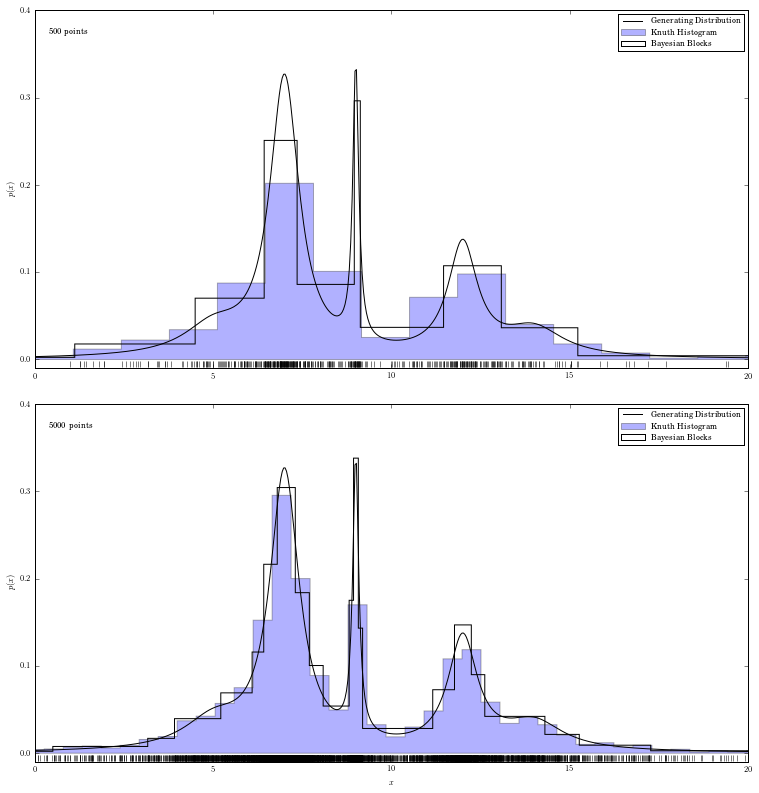

In [3]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

from astroML.plotting import hist

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate our data: a mix of several Cauchy distributions
np.random.seed(0)
N = 10000
mu_gamma_f = [(5, 1.0, 0.1),
              (7, 0.5, 0.5),
              (9, 0.1, 0.1),
              (12, 0.5, 0.2),
              (14, 1.0, 0.1)]
true_pdf = lambda x: np.sum([f * stats.cauchy(mu, gamma).pdf(x)
                          for (mu, gamma, f) in mu_gamma_f], axis=0)
x = np.concatenate([stats.cauchy(mu, gamma).rvs(int(f * N))
                    for (mu, gamma, f) in mu_gamma_f])
np.random.shuffle(x)
x = x[x > -10]
x = x[x < 30]

#------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(12, 12))
fig.subplots_adjust(bottom=0.08, top=0.95, right=0.95, hspace=0.1)
N_values = (500, 5000)
subplots = (211, 212)

for N, subplot in zip(N_values, subplots):
    ax = fig.add_subplot(subplot)
    xN = x[:N]
    t = np.linspace(-10, 30, 1000)

    # plot the results
    ax.plot(xN, -0.005 * np.ones(len(xN)), '|k')
    hist(xN, bins='knuth', ax=ax, normed=True,
         histtype='stepfilled', alpha=0.3,
         label='Knuth Histogram')
    hist(xN, bins='blocks', ax=ax, normed=True,
         histtype='step', color='k',
         label="Bayesian Blocks")
    ax.plot(t, true_pdf(t), '-', color='black',
            label="Generating Distribution")

    # label the plot
    ax.text(0.02, 0.95, "%i points" % N, ha='left', va='top',
            transform=ax.transAxes)
    ax.set_ylabel('$p(x)$')
    ax.legend(loc='upper right', prop=dict(size=8))

    if subplot == 212:
        ax.set_xlabel('$x$')

    ax.set_xlim(0, 20)
    ax.set_ylim(-0.01, 0.4001)

plt.show()

<h2>5.8 Numerical Methods for Complex Problems</h2>

When the number of parameters in a model is 'high', exhaustive serach of the parameter space becomes impractical (another instance of the 'curse of dimensionality,' in fact the same problem as when using e.g. SciKit-Learn's GridSearch classes/methods for cross validation.)  In this case, 'high' depends on the number of parameter points (range / parameter value spacing); if there are 100 parameter values to check, and 5 parameters there are 10 billion possible combinations, so alread 5 is 'high' if we assume the models are non-trivial to compute and/or check.

Defining

$$
p(\vec{\theta}) \equiv p(M(\vec{\theta})|D,I) \propto p(D|M(\vec{\theta},I)p(\vec{\theta}|I)
$$

and

$$
I(\vec{\theta}) = \int g(\vec{\theta})p(\vec{\theta}) d\theta_{i...j}
$$

where the subset of $\vec{\theta}$ integrated over, and value of $g(\vec{\theta})$ depends on what is desired.  (e.g. with $g(\vec{\theta}) = 1$ and over nuisance parameters to give the posterior pdf over parameters of interest.)

In order to reduce computation, we can randomly select parameters from the parameter space to check; not having any prior information, the most straight-forward choice of uniform sampling is sensible.  (Though other choices could be made; see e.g. SciKit-Learn's <a href="http://scikit-learn.org/stable/modules/generated/sklearn.grid_search.ParameterSampler.html#sklearn.grid_search.ParameterSampler">sklearn.grid_search.ParameterSampler</a>).  This is generic Monte Carlo.  With a set of M random $\vec{\theta}$ uniformly sampled from the integration volume $V_\theta$,

$$
I \approx \frac{V_\theta}{M}{\displaystyle \sum_{i=1}^{M}}g(\theta_i)p(\theta_i)
$$

This is inefficient with the integrated function varies greatly within the volume (and would suffer from the 'regular' numerical integration issues of e.g. grid-size vs. rapid variation, I imagine.)  Out of a number of alternate methods, Markov Chain Monte Carlo is the most popular.  This method returns a sample of points with a distributuon asymptotically proportional to $p(\theta)$.  Then:

$$
I \approx \frac{1}{M}{\displaystyle \sum_{i=1}^{M}}g(\theta_i)
$$

The marginalized pdf for a parameter can be estimated/visualized by building a normalized histogram:

 [-----------------100%-----------------] 50000 of 50000 complete in 12.8 sec

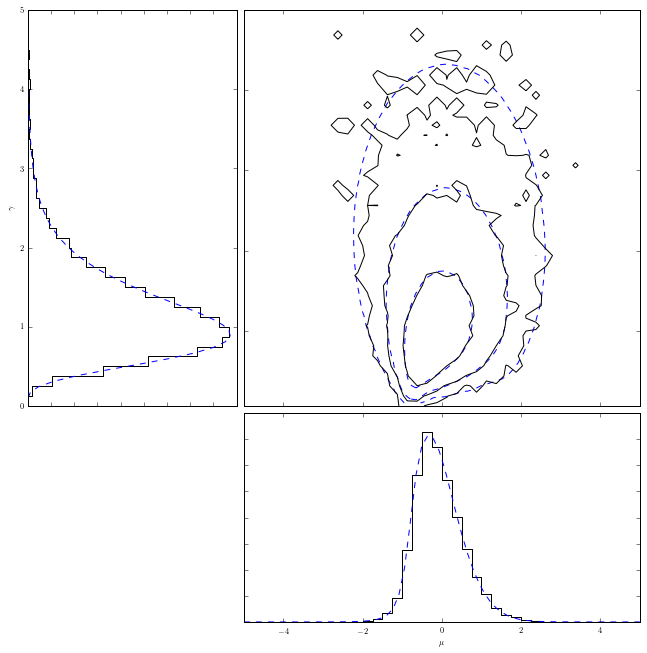

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from scipy.stats import cauchy
from matplotlib import pyplot as plt
from astroML.plotting.mcmc import convert_to_stdev

# this fixes a problem when using older versions of pymc with newer
# versions of scipy
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def cauchy_logL(xi, sigma, mu):
    """Equation 5.74: cauchy likelihood"""
    xi = np.asarray(xi)
    n = xi.size
    shape = np.broadcast(sigma, mu).shape

    xi = xi.reshape(xi.shape + tuple([1 for s in shape]))

    return ((n - 1) * np.log(sigma)
            - np.sum(np.log(sigma ** 2 + (xi - mu) ** 2), 0))


#----------------------------------------------------------------------
# Draw the sample from a Cauchy distribution
np.random.seed(44)
mu_0 = 0
gamma_0 = 2
xi = cauchy(mu_0, gamma_0).rvs(10)

#----------------------------------------------------------------------
# Perform MCMC:

# set up our Stochastic variables, mu and gamma
mu = pymc.Uniform('mu', -5, 5)
log_gamma = pymc.Uniform('log_gamma', -10, 10, value=0)


@pymc.deterministic
def gamma(log_gamma=log_gamma):
    return np.exp(log_gamma)

# set up our observed variable x
x = pymc.Cauchy('x', mu, gamma, observed=True, value=xi)

# set up our model dictionary
model = dict(mu=mu, log_gamma=log_gamma, gamma=gamma, x=x)

# perform the MCMC
S = pymc.MCMC(model)
S.sample(iter=50000, burn=5000)

# extract the traces we're interested in
trace_mu = S.trace('mu')[:]
trace_gamma = S.trace('gamma')[:]

# compute histogram of results to plot below
L_MCMC, mu_bins, gamma_bins = np.histogram2d(trace_mu, trace_gamma,
                                             bins=(np.linspace(-5, 5, 41),
                                                   np.linspace(0, 5, 41)))
L_MCMC[L_MCMC == 0] = 1E-16  # prevents zero-division errors

#----------------------------------------------------------------------
# Compute likelihood analytically for comparison
mu = np.linspace(-5, 5, 70)
gamma = np.linspace(0.1, 5, 70)
logL = cauchy_logL(xi, gamma[:, np.newaxis], mu)
logL -= logL.max()

p_mu = np.exp(logL).sum(0)
p_mu /= p_mu.sum() * (mu[1] - mu[0])

p_gamma = np.exp(logL).sum(1)
p_gamma /= p_gamma.sum() * (gamma[1] - gamma[0])

hist_mu, bins_mu = np.histogram(trace_mu, bins=mu_bins, normed=True)
hist_gamma, bins_gamma = np.histogram(trace_gamma, bins=gamma_bins,
                                      normed=True)


#----------------------------------------------------------------------
# plot the results
fig = plt.figure(figsize=(10, 10))

# first axis: likelihood contours
ax1 = fig.add_axes((0.4, 0.4, 0.55, 0.55))
ax1.xaxis.set_major_formatter(plt.NullFormatter())
ax1.yaxis.set_major_formatter(plt.NullFormatter())

ax1.contour(mu, gamma, convert_to_stdev(logL),
            levels=(0.683, 0.955, 0.997),
            colors='b', linestyles='dashed')

ax1.contour(0.5 * (mu_bins[:-1] + mu_bins[1:]),
            0.5 * (gamma_bins[:-1] + gamma_bins[1:]),
            convert_to_stdev(np.log(L_MCMC.T)),
            levels=(0.683, 0.955, 0.997),
            colors='k')

# second axis: marginalized over mu
ax2 = fig.add_axes((0.1, 0.4, 0.29, 0.55))
ax2.xaxis.set_major_formatter(plt.NullFormatter())
ax2.plot(hist_gamma, 0.5 * (bins_gamma[1:] + bins_gamma[:-1]
                            - bins_gamma[1] + bins_gamma[0]),
         '-k', drawstyle='steps')
ax2.plot(p_gamma, gamma, '--b')
ax2.set_ylabel(r'$\gamma$')
ax2.set_ylim(0, 5)

# third axis: marginalized over gamma
ax3 = fig.add_axes((0.4, 0.1, 0.55, 0.29))
ax3.yaxis.set_major_formatter(plt.NullFormatter())
ax3.plot(0.5 * (bins_mu[1:] + bins_mu[:-1]), hist_mu,
         '-k', drawstyle='steps-mid')
ax3.plot(mu, p_mu, '--b')
ax3.set_xlabel(r'$\mu$')
plt.xlim(-5, 5)

plt.show()

<h3>5.8.1-5.8.3 Markov Chain Monte Carlo</h3>

A Markov chain is a Markov process with a finite number of states; a Markov process is one where the probability that a state <i>x</i> transitions to a new state <i>y</i> depends only only on the two states <i>x</i> and <i>y</i>.  As the book sums up:

$$
p(\theta_{i+1}|\{\theta_i\})=p(\theta_{i+1}|\theta_i)
$$

We reach a stationary point when

$$
p(\theta_{i+1}|\theta_i)=p(\theta_i|\theta_{i+1})
$$

In order for a Markov chain to reach a stationary ditribution proportional to $p(\vec{theta})$, the probability of arriving at a point $\theta_{i+1}$ is proportional to $p(\theta_{i+1})$,

$$
p(\theta_{i+1}) = \int T(\theta_{i+1}|\theta_i)p(\theta_i) d\theta_i
$$

with $T(\theta_{i+1}|\theta_i)$ being the jump (or transition) kernel.

The most famous algorithm for generating a Markov chain is the Metropolis-Hastings algorithm, though <a href="https://en.wikipedia.org/wiki/Markov_chain_Monte_Carlo#Random_walk_Monte_Carlo_methods">many others exist</a> that avoid Metropolis-Hastings pitfalls e.g. getting stuck at a local maxima in the posterior pdf.  In the Metropolis-Hastings algorithm the jump kernel is:

$$
T(\theta_{i+1}|\theta_i) = p_{acc}(\theta_i, \theta_{i+1})K(\theta_{i+1}|\theta_i)
$$

(see <a href="https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm#Formal_derivation_of_the_Metropolis-Hastings_algorithm">this straight-forward derivation</a> for more details) and

$$
p_{acc} = min \left( 1, \frac{K(\theta_i|\theta_{i+1})p(\theta_{i+1})}{K(\theta_{i+1}|\theta_i)p(\theta_i)} \right)
$$

When $\theta_{i+1}$ is rejected, $\theta_i$ is added to the chain instead.

The Metropolis-Hastings algorithm requires a burn-in period; there is not a gernal, theoretical answer to how long this period is.  Examples in the book use a "safe" number of 5000 (discarding the first 5000 elements of a chain.)  Other non-arbitrary, methods exist (see middle paragraph of page 233.)

<h3> 5.8.4 Model Selection with MCMC</h3>

Given a Gaussian mixture model with two underlying distributions, how does MCMC fit into choosing amongst competing models (in this simple case, between a single Gaussian and a two Gaussian mixture model)?  We already did this in Chapter 4, and at that time the AIC was shown to be able to answer the question.  Again, we find that AIC (and BIC) are able to determine the correct class (a bimodal Gaussian):

AttributeError: 'GMM' object has no attribute 'eval'

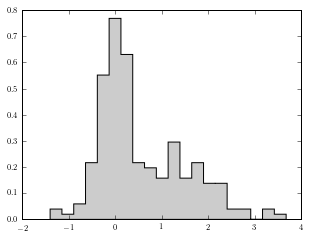

In [4]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm
from astroML.density_estimation import GaussianMixture1D

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

#------------------------------------------------------------
# Generate the data
mu1_in = 0
sigma1_in = 0.3
mu2_in = 1
sigma2_in = 1
ratio_in = 1.5
N = 200

np.random.seed(10)
gm = GaussianMixture1D([mu1_in, mu2_in],
                       [sigma1_in, sigma2_in],
                       [ratio_in, 1])
x_sample = gm.sample(N)

#------------------------------------------------------------
# Get the MLE fit for a single gaussian
sample_mu = np.mean(x_sample)
sample_std = np.std(x_sample, ddof=1)

#------------------------------------------------------------
# Plot the sampled data
fig, ax = plt.subplots(figsize=(5, 3.75))

ax.hist(x_sample, 20, histtype='stepfilled', normed=True, fc='#CCCCCC')
x = np.linspace(-2.1, 4.1, 1000)

factor1 = ratio_in / (1. + ratio_in)
factor2 = 1. / (1. + ratio_in)

ax.plot(x, gm.pdf(x), '-k', label='true distribution')
ax.plot(x, gm.pdf_individual(x), ':k')

ax.plot(x, norm.pdf(x, sample_mu, sample_std), '--k', label='best fit normal')

ax.legend(loc=1)

ax.set_xlim(-2.1, 4.1)

ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
ax.set_title('Input pdf and sampled data')
ax.text(0.95, 0.80, ('$\mu_1 = 0;\ \sigma_1=0.3$\n'
                     '$\mu_2=1;\ \sigma_2=1.0$\n'
                     '$\mathrm{ratio}=1.5$'),
        transform=ax.transAxes, ha='right', va='top')
plt.show()

 [-----------------100%-----------------] 10000 of 10000 complete in 141.8 sec
Bayes Factor (???): 1085356178.88 



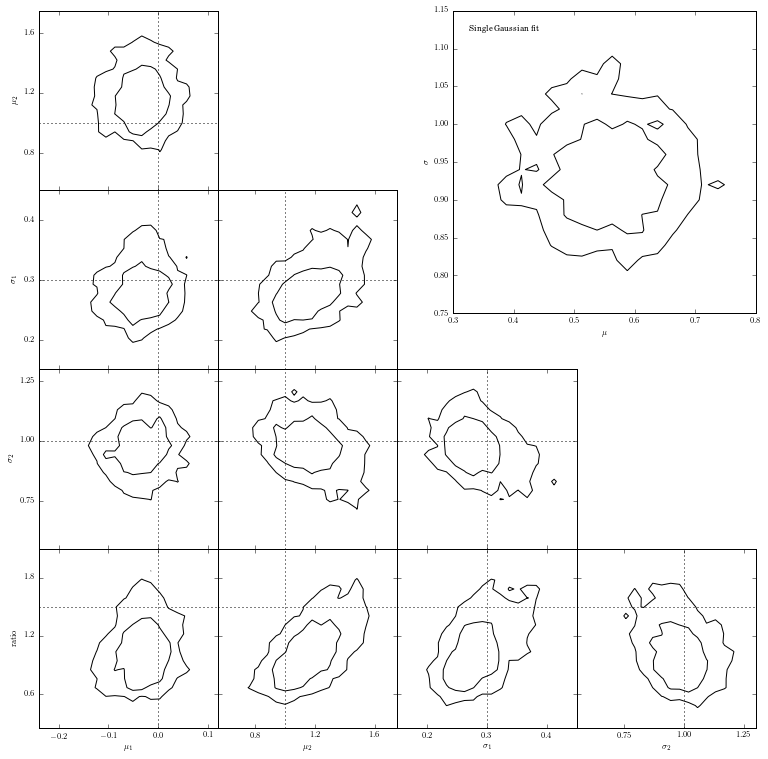

In [12]:
# Author: Jake VanderPlas
# License: BSD
#   The figure produced by this code is published in the textbook
#   "Statistics, Data Mining, and Machine Learning in Astronomy" (2013)
#   For more information, see http://astroML.github.com
#   To report a bug or issue, use the following forum:
#    https://groups.google.com/forum/#!forum/astroml-general
import numpy as np
from matplotlib import pyplot as plt

from scipy.special import gamma
from scipy.stats import norm
from sklearn.neighbors import BallTree
from astroML.density_estimation import GaussianMixture1D
from astroML.plotting import plot_mcmc
# hack to fix an import issue in older versions of pymc
import scipy
scipy.derivative = scipy.misc.derivative
import pymc

#----------------------------------------------------------------------
# This function adjusts matplotlib settings for a uniform feel in the textbook.
# Note that with usetex=True, fonts are rendered with LaTeX.  This may
# result in an error if LaTeX is not installed on your system.  In that case,
# you can set usetex to False.
from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)


def get_logp(S, model):
    """compute log(p) given a pyMC model"""
    M = pymc.MAP(model)
    traces = np.array([S.trace(s)[:] for s in S.stochastics])
    logp = np.zeros(traces.shape[1])
    for i in range(len(logp)):
        logp[i] = -M.func(traces[:, i])
    return logp


def estimate_bayes_factor(traces, logp, r=0.05, return_list=False):
    """Estimate the bayes factor using the local density of points"""
    D, N = traces.shape

    # compute volume of a D-dimensional sphere of radius r
    Vr = np.pi ** (0.5 * D) / gamma(0.5 * D + 1) * (r ** D)

    # use neighbor count within r as a density estimator
    bt = BallTree(traces.T)
    count = bt.query_radius(traces.T, r=r, count_only=True)

    BF = logp + np.log(N) + np.log(Vr) - np.log(count)

    if return_list:
        return BF
    else:
        p25, p50, p75 = np.percentile(BF, [25, 50, 75])
        return p50, 0.7413 * (p75 - p25)


#------------------------------------------------------------
# Generate the data
mu1_in = 0
sigma1_in = 0.3
mu2_in = 1
sigma2_in = 1
ratio_in = 1.5
N = 200

np.random.seed(10)
gm = GaussianMixture1D([mu1_in, mu2_in],
                       [sigma1_in, sigma2_in],
                       [ratio_in, 1])
x_sample = gm.sample(N)

#------------------------------------------------------------
# Set up pyMC model: single gaussian
#  2 parameters: (mu, sigma)
M1_mu = pymc.Uniform('M1_mu', -5, 5, value=0)
M1_log_sigma = pymc.Uniform('M1_log_sigma', -10, 10, value=0)


@pymc.deterministic
def M1_sigma(M1_log_sigma=M1_log_sigma):
    return np.exp(M1_log_sigma)


@pymc.deterministic
def M1_tau(M1_sigma=M1_sigma):
    return 1. / M1_sigma ** 2

M1 = pymc.Normal('M1', M1_mu, M1_tau, observed=True, value=x_sample)
model1 = dict(M1_mu=M1_mu, M1_log_sigma=M1_log_sigma,
              M1_sigma=M1_sigma,
              M1_tau=M1_tau, M1=M1)


#------------------------------------------------------------
# Set up pyMC model: double gaussian
#  5 parameters: (mu1, mu2, sigma1, sigma2, ratio)

def doublegauss_like(x, mu1, mu2, sigma1, sigma2, ratio):
    """log-likelihood for double gaussian"""
    r1 = ratio / (1. + ratio)
    r2 = 1 - r1
    L = r1 * norm(mu1, sigma1).pdf(x) + r2 * norm(mu2, sigma2).pdf(x)
    L[L == 0] = 1E-16  # prevent divide-by-zero error
    logL = np.log(L).sum()
    if np.isinf(logL):
        raise pymc.ZeroProbability
    else:
        return logL


def rdoublegauss(mu1, mu2, sigma1, sigma2, ratio, size=None):
    """random variable from double gaussian"""
    r1 = ratio / (1. + ratio)
    r2 = 1 - r1
    R = np.asarray(np.random.random(size))

    Rshape = R.shape
    R = np.atleast1d(R)

    mask1 = (R < r1)
    mask2 = ~mask1
    N1 = mask1.sum()
    N2 = R.size - N1

    R[mask1] = norm(mu1, sigma1).rvs(N1)
    R[mask2] = norm(mu2, sigma2).rvs(N2)

    return R.reshape(Rshape)

DoubleGauss = pymc.stochastic_from_dist('doublegauss',
                                        logp=doublegauss_like,
                                        random=rdoublegauss,
                                        dtype=np.float,
                                        mv=True)

# set up our Stochastic variables, mu1, mu2, sigma1, sigma2, ratio
M2_mu1 = pymc.Uniform('M2_mu1', -5, 5, value=0)
M2_mu2 = pymc.Uniform('M2_mu2', -5, 5, value=1)

M2_log_sigma1 = pymc.Uniform('M2_log_sigma1', -10, 10, value=0)
M2_log_sigma2 = pymc.Uniform('M2_log_sigma2', -10, 10, value=0)


@pymc.deterministic
def M2_sigma1(M2_log_sigma1=M2_log_sigma1):
    return np.exp(M2_log_sigma1)


@pymc.deterministic
def M2_sigma2(M2_log_sigma2=M2_log_sigma2):
    return np.exp(M2_log_sigma2)

M2_ratio = pymc.Uniform('M2_ratio', 1E-3, 1E3, value=1)

M2 = DoubleGauss('M2', M2_mu1, M2_mu2, M2_sigma1, M2_sigma2, M2_ratio,
                 observed=True, value=x_sample)

model2 = dict(M2_mu1=M2_mu1, M2_mu2=M2_mu2,
              M2_log_sigma1=M2_log_sigma1, M2_log_sigma2=M2_log_sigma2,
              M2_sigma1=M2_sigma1, M2_sigma2=M2_sigma2,
              M2_ratio=M2_ratio, M2=M2)


#------------------------------------------------------------
# Set up MCMC sampling
def compute_MCMC_models(Niter=10000, burn=1000, rseed=0):
    pymc.numpy.random.seed(rseed)

    S1 = pymc.MCMC(model1)
    S1.sample(iter=Niter, burn=burn)
    trace1 = np.vstack([S1.trace('M1_mu')[:],
                        S1.trace('M1_sigma')[:]])
    logp1 = get_logp(S1, model1)

    S2 = pymc.MCMC(model2)
    S2.sample(iter=Niter, burn=burn)
    trace2 = np.vstack([S2.trace('M2_mu1')[:],
                        S2.trace('M2_mu2')[:],
                        S2.trace('M2_sigma1')[:],
                        S2.trace('M2_sigma2')[:],
                        S2.trace('M2_ratio')[:]])
    logp2 = get_logp(S2, model2)

    return trace1, logp1, trace2, logp2

trace1, logp1, trace2, logp2 = compute_MCMC_models()


#------------------------------------------------------------
# Compute Odds ratio with density estimation technique
'''
BF1 = estimate_bayes_factor(trace1, logp1, r=0.02, return_list=True)
BF2 = estimate_bayes_factor(trace2, logp2, r=0.05, return_list=True)

print BF1
print BF2

'''
BF1, dBF1 = estimate_bayes_factor(trace1, logp1, r=0.02, return_list=False)
BF2, dBF2 = estimate_bayes_factor(trace2, logp2, r=0.05, return_list=False)

print "\nBayes Factor (???):", np.exp(BF2-BF1), "\n"


#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 12))

labels = [r'$\mu_1$',
          r'$\mu_2$',
          r'$\sigma_1$',
          r'$\sigma_2$',
          r'${\rm ratio}$']

true_values = [mu1_in,
               mu2_in,
               sigma1_in,
               sigma2_in,
               ratio_in]

limits = [(-0.24, 0.12),
          (0.55, 1.75),
          (0.15, 0.45),
          (0.55, 1.3),
          (0.25, 2.1)]

# we assume mu1 < mu2, but the results may be switched
#  due to the symmetry of the problem.  If so, switch back
if np.median(trace2[0]) > np.median(trace2[1]):
    trace2 = trace2[[1, 0, 3, 2, 4], :]
    N2_norm_mu = N2.mu[N2.M2_mu2, N2.M2_mu1,
                       N2.M2_sigma2, N2.M2_sigma1, N2.M2_ratio]
    N2_norm_Sig = N2.C[N2.M2_mu2, N2.M2_mu1,
                       N2.M2_sigma2, N2.M2_sigma1, N2.M2_ratio]

# Plot the simple 2-component model
ax, = plot_mcmc(trace1, fig=fig, bounds=[0.6, 0.6, 0.95, 0.95],
                limits=[(0.3, 0.8), (0.75, 1.15)],
                labels=[r'$\mu$', r'$\sigma$'], colors='k')

ax.text(0.05, 0.95, "Single Gaussian fit", va='top', ha='left',
        transform=ax.transAxes)

# Plot the 5-component model
ax_list = plot_mcmc(trace2, limits=limits, labels=labels,
                    true_values=true_values, fig=fig,
                    bounds=(0.12, 0.12, 0.95, 0.95),
                    colors='k')
for ax in ax_list:
    for axis in [ax.xaxis, ax.yaxis]:
        axis.set_major_locator(plt.MaxNLocator(4))

plt.show()

Though both AIC and BIC worked in this case, in general they are only applicable when the posterior distribution is approximately normal.  The more general approach is to employ the odds ratio; in this case the bi-modal model has 5 paramters, so we have a five dimensional case (as mentioned above) which is "computationally difficult."

Since

$$
L(M) = \int p(\vec(\theta)|\{x_i\}, I) d^k \theta
$$

and we compute a MCMC which is distributed (asymptotically) as $p(\vec(\theta)|\{x_i\}, I)$, the density of points $\rho$ in a region of the chain is proportional to the distribution.  So for a "well behaved" chain with $N$ points and proportionality constant $C$,

$$
\rho(\vec{\theta}) = C~N~p(\vec{\theta})
$$

Since $\int \rho(\vec{\theta}) = N$, we arrive at

$$
L(M) = \frac{N~p(\vec{\theta})}{\rho(\vec{\theta})}
$$

Density estimation is covered in Chapter 6, but the source code here implements it using a BallTree and counting points within fixed radius (though in the book it cites kernel estimation and an odds ratio of $10^{11}$ though, if my guess as to the meaning of the code is correct, I see a factor of $10^9$...)